<a href="https://colab.research.google.com/github/frizzyboi1/BreastCancerDetection/blob/main/BreastCancerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

# Modeling & evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# XGBoost (install if needed)
try:
    from xgboost import XGBClassifier
except ImportError:
    !pip install xgboost
    from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")


In [3]:
def load_dataset(csv_path: str) -> pd.DataFrame:
    """
    Load a CSV file into a pandas DataFrame.

    Parameters
    ----------
    csv_path : str
        Path to the CSV file.

    Returns
    -------
    pd.DataFrame
    """
    df = pd.read_csv(csv_path)
    print(f"✅ Data loaded. Shape: {df.shape[0]} rows, {df.shape[1]} columns")
    return df


In [4]:
# Example: if your file is named 'breast_cancer.csv'
df = load_dataset("breast-cancer.csv")


✅ Data loaded. Shape: 569 rows, 32 columns


In [5]:
def dataset_basic_info(df: pd.DataFrame) -> None:
    """
    Print basic information about the dataset:
    shape, dtypes, and missing values.
    """
    print("📌 Shape:", df.shape)
    print("\n📌 Data types:")
    print(df.dtypes)

    print("\n📌 Missing values per column:")
    print(df.isna().sum())


def summary_stats_numerical(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return summary statistics for numerical variables.
    """
    num_df = df.select_dtypes(include=[np.number])
    print(f"🧮 Numerical features: {list(num_df.columns)}")
    return num_df.describe().T


def summary_stats_categorical(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return summary statistics for categorical variables.
    """
    cat_df = df.select_dtypes(include=["object", "category", "bool"])
    if cat_df.shape[1] == 0:
        print("ℹ️ No categorical features detected.")
        return pd.DataFrame()

    print(f"🔤 Categorical features: {list(cat_df.columns)}")
    return cat_df.describe().T


In [6]:
dataset_basic_info(df)

num_summary = summary_stats_numerical(df)
display(num_summary)

cat_summary = summary_stats_categorical(df)
display(cat_summary)


📌 Shape: (569, 32)

📌 Data types:
id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst    

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037e+07,1.250e+08,8.670e+03,869218.000,906024.000,8.813e+06,9.113e+08
radius_mean,569.0,1.413e+01,3.524e+00,6.981e+00,11.700,13.370,1.578e+01,2.811e+01
texture_mean,569.0,1.929e+01,4.301e+00,9.710e+00,16.170,18.840,2.180e+01,3.928e+01
perimeter_mean,569.0,9.197e+01,2.430e+01,4.379e+01,75.170,86.240,1.041e+02,1.885e+02
area_mean,569.0,6.549e+02,3.519e+02,1.435e+02,420.300,551.100,7.827e+02,2.501e+03
smoothness_mean,569.0,9.636e-02,1.406e-02,5.263e-02,0.086,0.096,1.053e-01,1.634e-01
compactness_mean,569.0,1.043e-01,5.281e-02,1.938e-02,0.065,0.093,1.304e-01,3.454e-01
concavity_mean,569.0,8.880e-02,7.972e-02,0.000e+00,0.030,0.062,1.307e-01,4.268e-01
concave points_mean,569.0,4.892e-02,3.880e-02,0.000e+00,0.020,0.034,7.400e-02,2.012e-01
symmetry_mean,569.0,1.812e-01,2.741e-02,1.060e-01,0.162,0.179,1.957e-01,3.040e-01


🔤 Categorical features: ['diagnosis']


,count,unique,top,freq
diagnosis,569,2,B,357


In [7]:
def dataset_basic_info(df):
    print("📌 Dataset Shape:", df.shape)
    print("\n📌 Data Types:\n", df.dtypes)
    print("\n📌 Missing Values:\n", df.isna().sum())


In [8]:
def summary_stats_numerical(df):
    num_df = df.select_dtypes(include=['float64', 'int64'])
    print(f"🧮 Numerical Features ({len(num_df.columns)}):")
    return num_df.describe().T


In [9]:
def summary_stats_categorical(df):
    cat_df = df.select_dtypes(include=['object', 'category'])
    if cat_df.shape[1] == 0:
        print("ℹ️ No categorical features found.")
        return pd.DataFrame()
    print(f"🔤 Categorical Features ({len(cat_df.columns)}):")
    return cat_df.describe().T


In [10]:
dataset_basic_info(df)
display(summary_stats_numerical(df))
display(summary_stats_categorical(df))


📌 Dataset Shape: (569, 32)

📌 Data Types:
 id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037e+07,1.250e+08,8.670e+03,869218.000,906024.000,8.813e+06,9.113e+08
radius_mean,569.0,1.413e+01,3.524e+00,6.981e+00,11.700,13.370,1.578e+01,2.811e+01
texture_mean,569.0,1.929e+01,4.301e+00,9.710e+00,16.170,18.840,2.180e+01,3.928e+01
perimeter_mean,569.0,9.197e+01,2.430e+01,4.379e+01,75.170,86.240,1.041e+02,1.885e+02
area_mean,569.0,6.549e+02,3.519e+02,1.435e+02,420.300,551.100,7.827e+02,2.501e+03
smoothness_mean,569.0,9.636e-02,1.406e-02,5.263e-02,0.086,0.096,1.053e-01,1.634e-01
compactness_mean,569.0,1.043e-01,5.281e-02,1.938e-02,0.065,0.093,1.304e-01,3.454e-01
concavity_mean,569.0,8.880e-02,7.972e-02,0.000e+00,0.030,0.062,1.307e-01,4.268e-01
concave points_mean,569.0,4.892e-02,3.880e-02,0.000e+00,0.020,0.034,7.400e-02,2.012e-01
symmetry_mean,569.0,1.812e-01,2.741e-02,1.060e-01,0.162,0.179,1.957e-01,3.040e-01


🔤 Categorical Features (1):


,count,unique,top,freq
diagnosis,569,2,B,357


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style="whitegrid")

TARGET_COL = "diagnosis"

# Separate column types
id_cols = ["id"] if "id" in df.columns else []

num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_cols = [c for c in num_cols if c not in id_cols]  # drop id from numeric list if present

cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != TARGET_COL]   # exclude target from "features"

print("Numeric features:", len(num_cols))
print(num_cols[:10], "..." if len(num_cols) > 10 else "")
print("\nCategorical features:", len(cat_cols))
print(cat_cols)
print("\nTarget column:", TARGET_COL)


Numeric features: 30
['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean'] ...

Categorical features: 0
[]

Target column: diagnosis


In [12]:
def plot_univariate_numerical(df, num_columns=None, bins=30):
    """
    Plots histograms with KDE for numerical columns.
    """
    if num_columns is None:
        num_columns = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

    # Avoid id if present
    num_columns = [c for c in num_columns if c not in ["id"]]

    n = len(num_columns)
    if n == 0:
        print("No numerical columns to plot.")
        return

    cols_per_row = 3
    rows = int(np.ceil(n / cols_per_row))

    plt.figure(figsize=(6 * cols_per_row, 4 * rows))

    for i, col in enumerate(num_columns, 1):
        plt.subplot(rows, cols_per_row, i)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(col)
        plt.xlabel("")

    plt.tight_layout()
    plt.show()


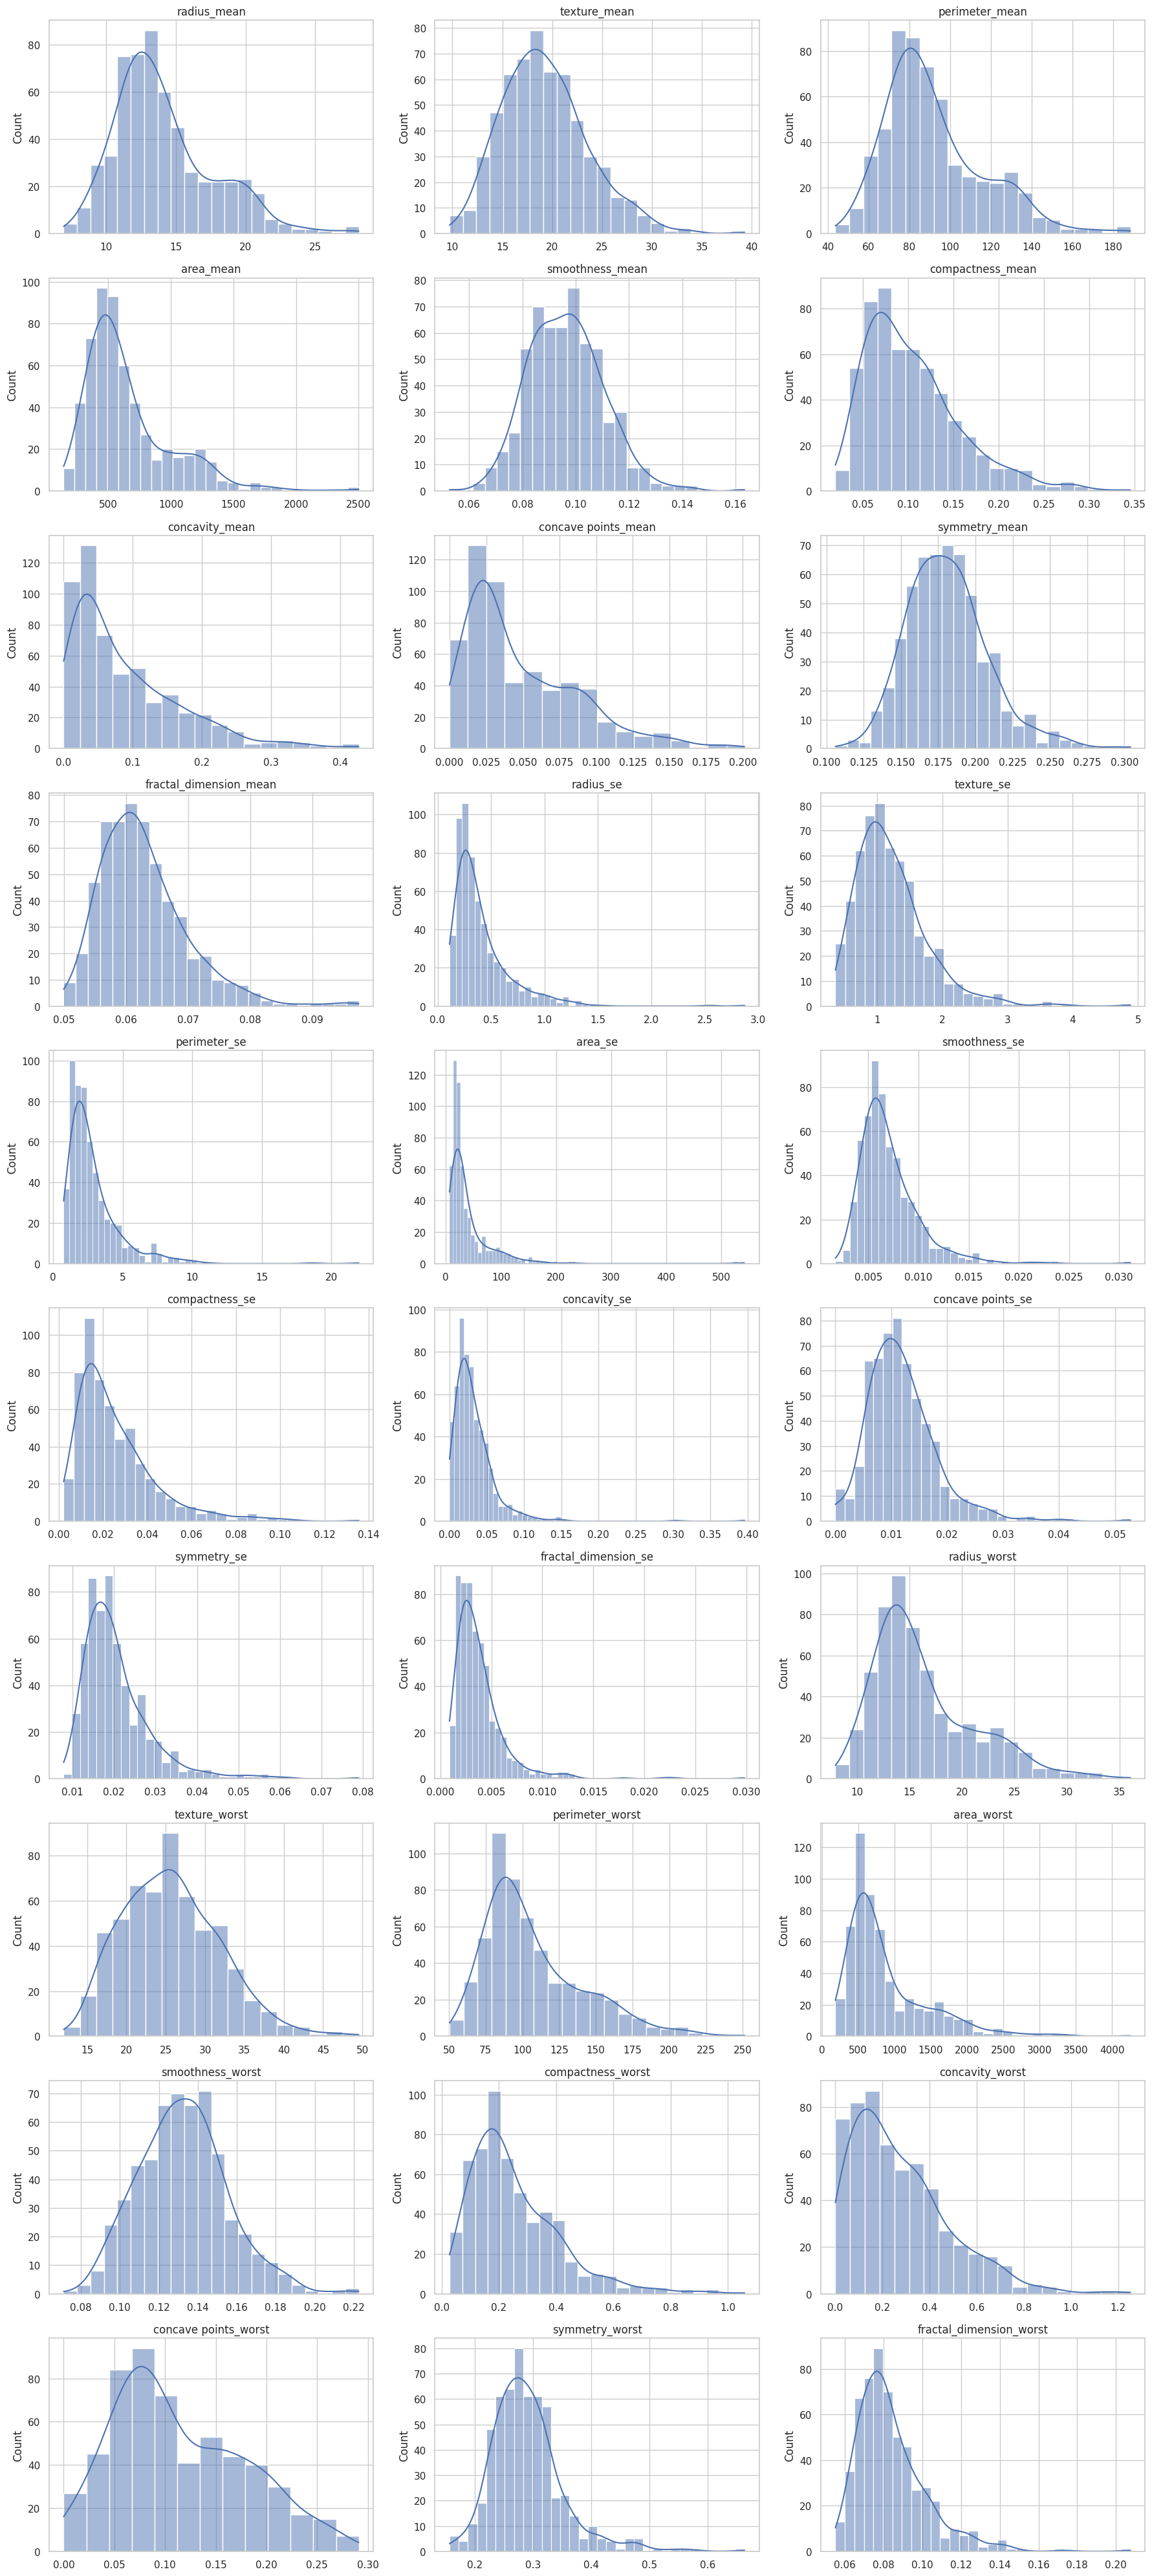

In [13]:
plot_univariate_numerical(df, num_cols)


In [14]:
def plot_univariate_categorical(df, cat_columns=None):
    """
    Plots countplots for categorical columns.
    """
    if cat_columns is None:
        cat_columns = df.select_dtypes(include=["object", "category"]).columns.tolist()

    # Exclude target from here if you only want features
    # but we *do* want to see class balance, so keep target explicitly.

    if len(cat_columns) == 0 and TARGET_COL in df.columns:
        cat_columns = [TARGET_COL]

    n = len(cat_columns)
    if n == 0:
        print("No categorical columns to plot.")
        return

    cols_per_row = 2
    rows = int(np.ceil(n / cols_per_row))

    plt.figure(figsize=(6 * cols_per_row, 4 * rows))

    for i, col in enumerate(cat_columns, 1):
        plt.subplot(rows, cols_per_row, i)
        sns.countplot(x=df[col])
        plt.title(col)
        plt.xlabel("")
        plt.ylabel("Count")
        plt.xticks(rotation=0)

    plt.tight_layout()
    plt.show()


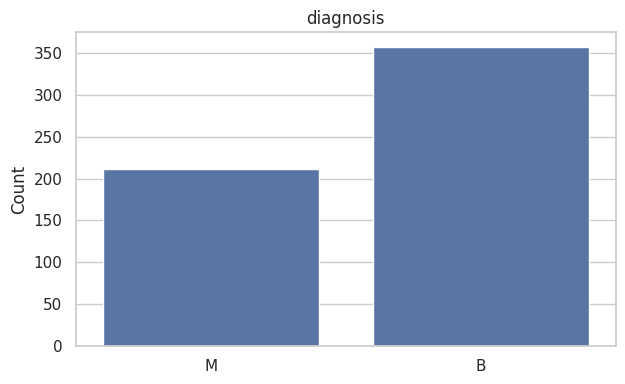

In [15]:
plot_univariate_categorical(df, cat_cols + [TARGET_COL])


In [16]:
def plot_bivariate_numerical_vs_target(df, target=TARGET_COL, num_columns=None, kind="box"):
    """
    Plots numerical features vs binary target using box/violin plots.

    kind: "box" or "violin"
    """
    if num_columns is None:
        num_columns = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

    num_columns = [c for c in num_columns if c not in ["id"]]  # remove id if present

    n = len(num_columns)
    if n == 0:
        print("No numerical columns to plot.")
        return

    cols_per_row = 3
    rows = int(np.ceil(n / cols_per_row))

    plt.figure(figsize=(6 * cols_per_row, 4 * rows))

    for i, col in enumerate(num_columns, 1):
        plt.subplot(rows, cols_per_row, i)
        if kind == "violin":
            sns.violinplot(x=df[target], y=df[col])
        else:
            sns.boxplot(x=df[target], y=df[col])
        plt.title(f"{col} vs {target}")
        plt.xlabel("")
        plt.ylabel("")

    plt.tight_layout()
    plt.show()


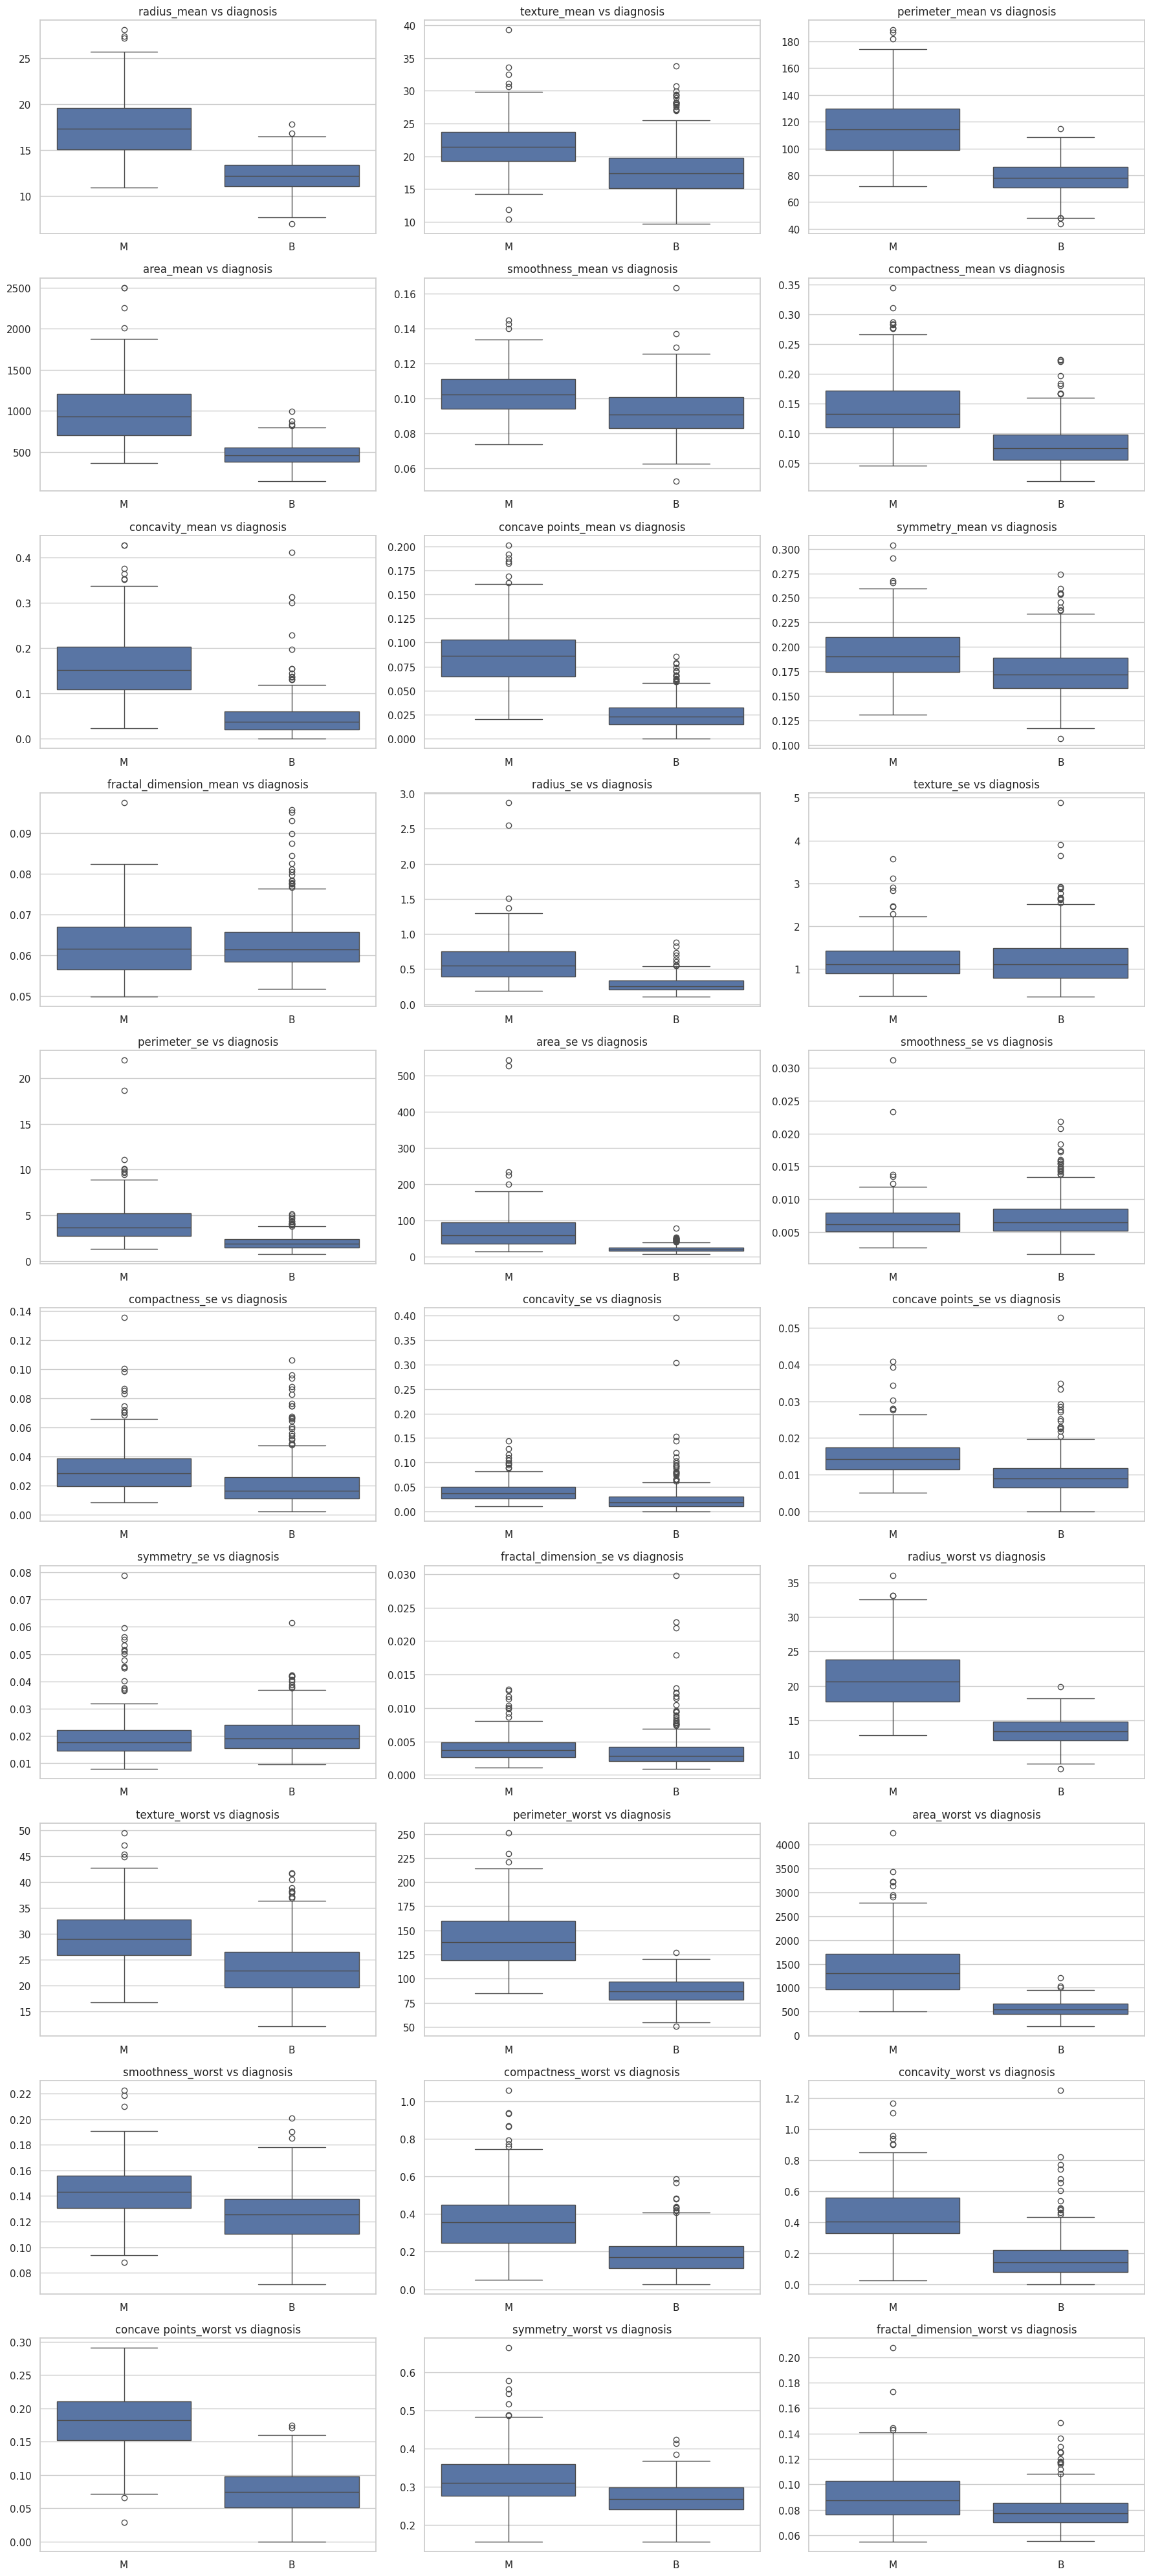

In [17]:
plot_bivariate_numerical_vs_target(df, target=TARGET_COL, num_columns=num_cols, kind="box")
# or
# plot_bivariate_numerical_vs_target(df, target=TARGET_COL, num_columns=num_cols, kind="violin")


In [18]:
def plot_bivariate_categorical_vs_target(df, target=TARGET_COL, cat_columns=None):
    """
    Plots categorical features vs target using grouped countplots.
    """
    if cat_columns is None:
        cat_columns = df.select_dtypes(include=["object", "category"]).columns.tolist()
        cat_columns = [c for c in cat_columns if c != target]

    if len(cat_columns) == 0:
        print("No non-target categorical columns to plot vs target.")
        return

    n = len(cat_columns)
    cols_per_row = 2
    rows = int(np.ceil(n / cols_per_row))

    plt.figure(figsize=(7 * cols_per_row, 4 * rows))

    for i, col in enumerate(cat_columns, 1):
        plt.subplot(rows, cols_per_row, i)
        sns.countplot(x=df[col], hue=df[target])
        plt.title(f"{col} vs {target}")
        plt.xlabel("")
        plt.ylabel("Count")
        plt.xticks(rotation=0)

    plt.tight_layout()
    plt.show()


In [19]:
plot_bivariate_categorical_vs_target(df, target=TARGET_COL, cat_columns=cat_cols)


No non-target categorical columns to plot vs target.


In [20]:
def plot_correlation_heatmap(df, num_columns=None, figsize=(14, 12), annot=False):
    """
    Plots a correlation heatmap for numerical variables.
    """
    if num_columns is None:
        num_columns = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

    corr = df[num_columns].corr()

    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=annot, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap of Numerical Features")
    plt.show()


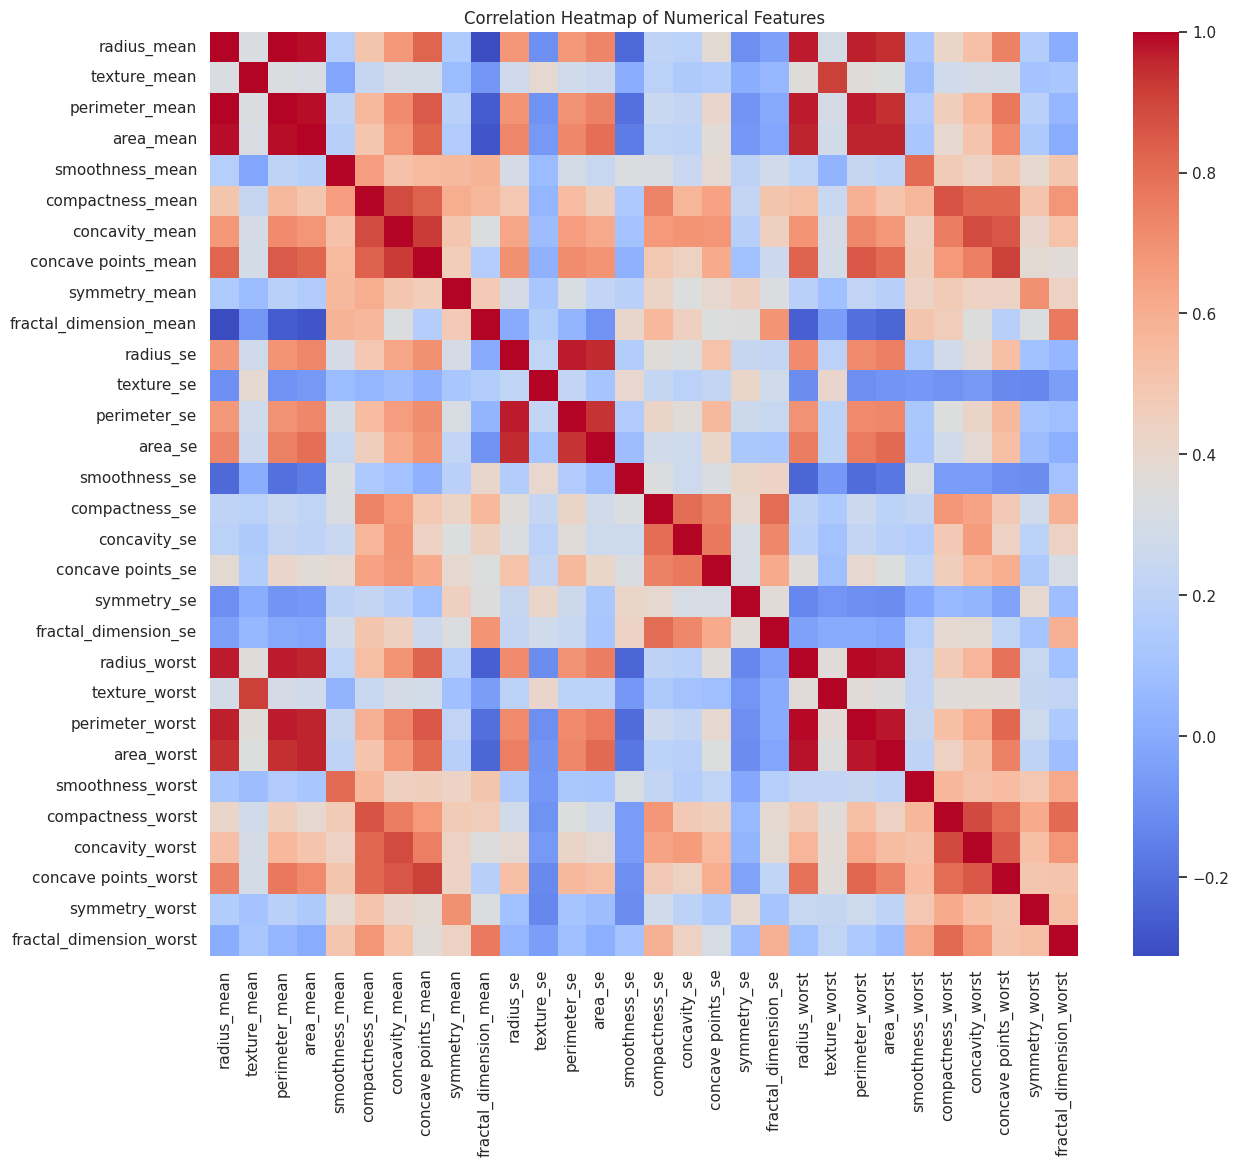

In [21]:
plot_correlation_heatmap(df, num_columns=num_cols, annot=False)


In [22]:
def plot_feature_target_correlation(df, target=TARGET_COL, num_columns=None, top_n=15):
    """
    Computes correlation of numerical features with the binary target (0/1)
    and plots the top_n most correlated.
    """
    # Map diagnosis to 0/1
    if df[target].dtype == "object":
        # Assuming 'M' = malignant, 'B' = benign
        target_map = {"M": 1, "B": 0}
        y = df[target].map(target_map)
    else:
        y = df[target]

    if num_columns is None:
        num_columns = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
        num_columns = [c for c in num_columns if c not in ["id"]]

    corr_values = {}
    for col in num_columns:
        corr_values[col] = np.corrcoef(df[col], y)[0, 1]

    corr_series = pd.Series(corr_values).dropna().sort_values(key=np.abs, ascending=False)

    top_corr = corr_series.head(top_n)

    plt.figure(figsize=(8, 0.5 * top_n + 2))
    sns.barplot(x=top_corr.values, y=top_corr.index)
    plt.title(f"Top {top_n} Features Correlated with {target} (1 = Malignant)")
    plt.xlabel("Correlation with target")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return top_corr


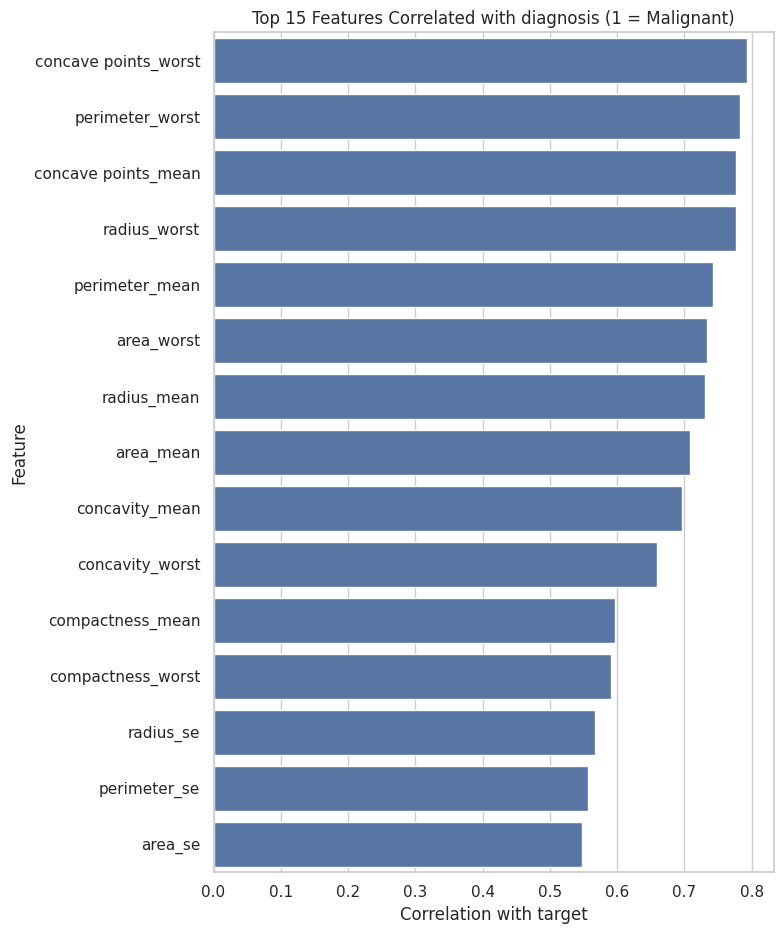

,0
concave points_worst,0.794
perimeter_worst,0.783
concave points_mean,0.777
radius_worst,0.776
perimeter_mean,0.743
area_worst,0.734
radius_mean,0.730
area_mean,0.709
concavity_mean,0.696
concavity_worst,0.660


In [23]:
top_corr = plot_feature_target_correlation(df, target=TARGET_COL, num_columns=num_cols, top_n=15)
top_corr


📌 Dataset Shape: (569, 32)

📌 Data Types:
 id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037e+07,1.250e+08,8.670e+03,869218.000,906024.000,8.813e+06,9.113e+08
radius_mean,569.0,1.413e+01,3.524e+00,6.981e+00,11.700,13.370,1.578e+01,2.811e+01
texture_mean,569.0,1.929e+01,4.301e+00,9.710e+00,16.170,18.840,2.180e+01,3.928e+01
perimeter_mean,569.0,9.197e+01,2.430e+01,4.379e+01,75.170,86.240,1.041e+02,1.885e+02
area_mean,569.0,6.549e+02,3.519e+02,1.435e+02,420.300,551.100,7.827e+02,2.501e+03
smoothness_mean,569.0,9.636e-02,1.406e-02,5.263e-02,0.086,0.096,1.053e-01,1.634e-01
compactness_mean,569.0,1.043e-01,5.281e-02,1.938e-02,0.065,0.093,1.304e-01,3.454e-01
concavity_mean,569.0,8.880e-02,7.972e-02,0.000e+00,0.030,0.062,1.307e-01,4.268e-01
concave points_mean,569.0,4.892e-02,3.880e-02,0.000e+00,0.020,0.034,7.400e-02,2.012e-01
symmetry_mean,569.0,1.812e-01,2.741e-02,1.060e-01,0.162,0.179,1.957e-01,3.040e-01


🔤 Categorical Features (1):


,count,unique,top,freq
diagnosis,569,2,B,357


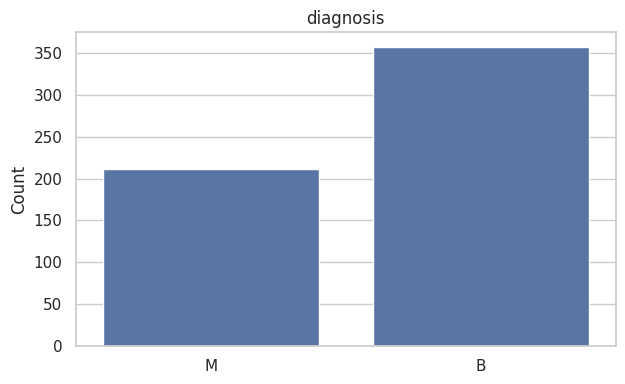

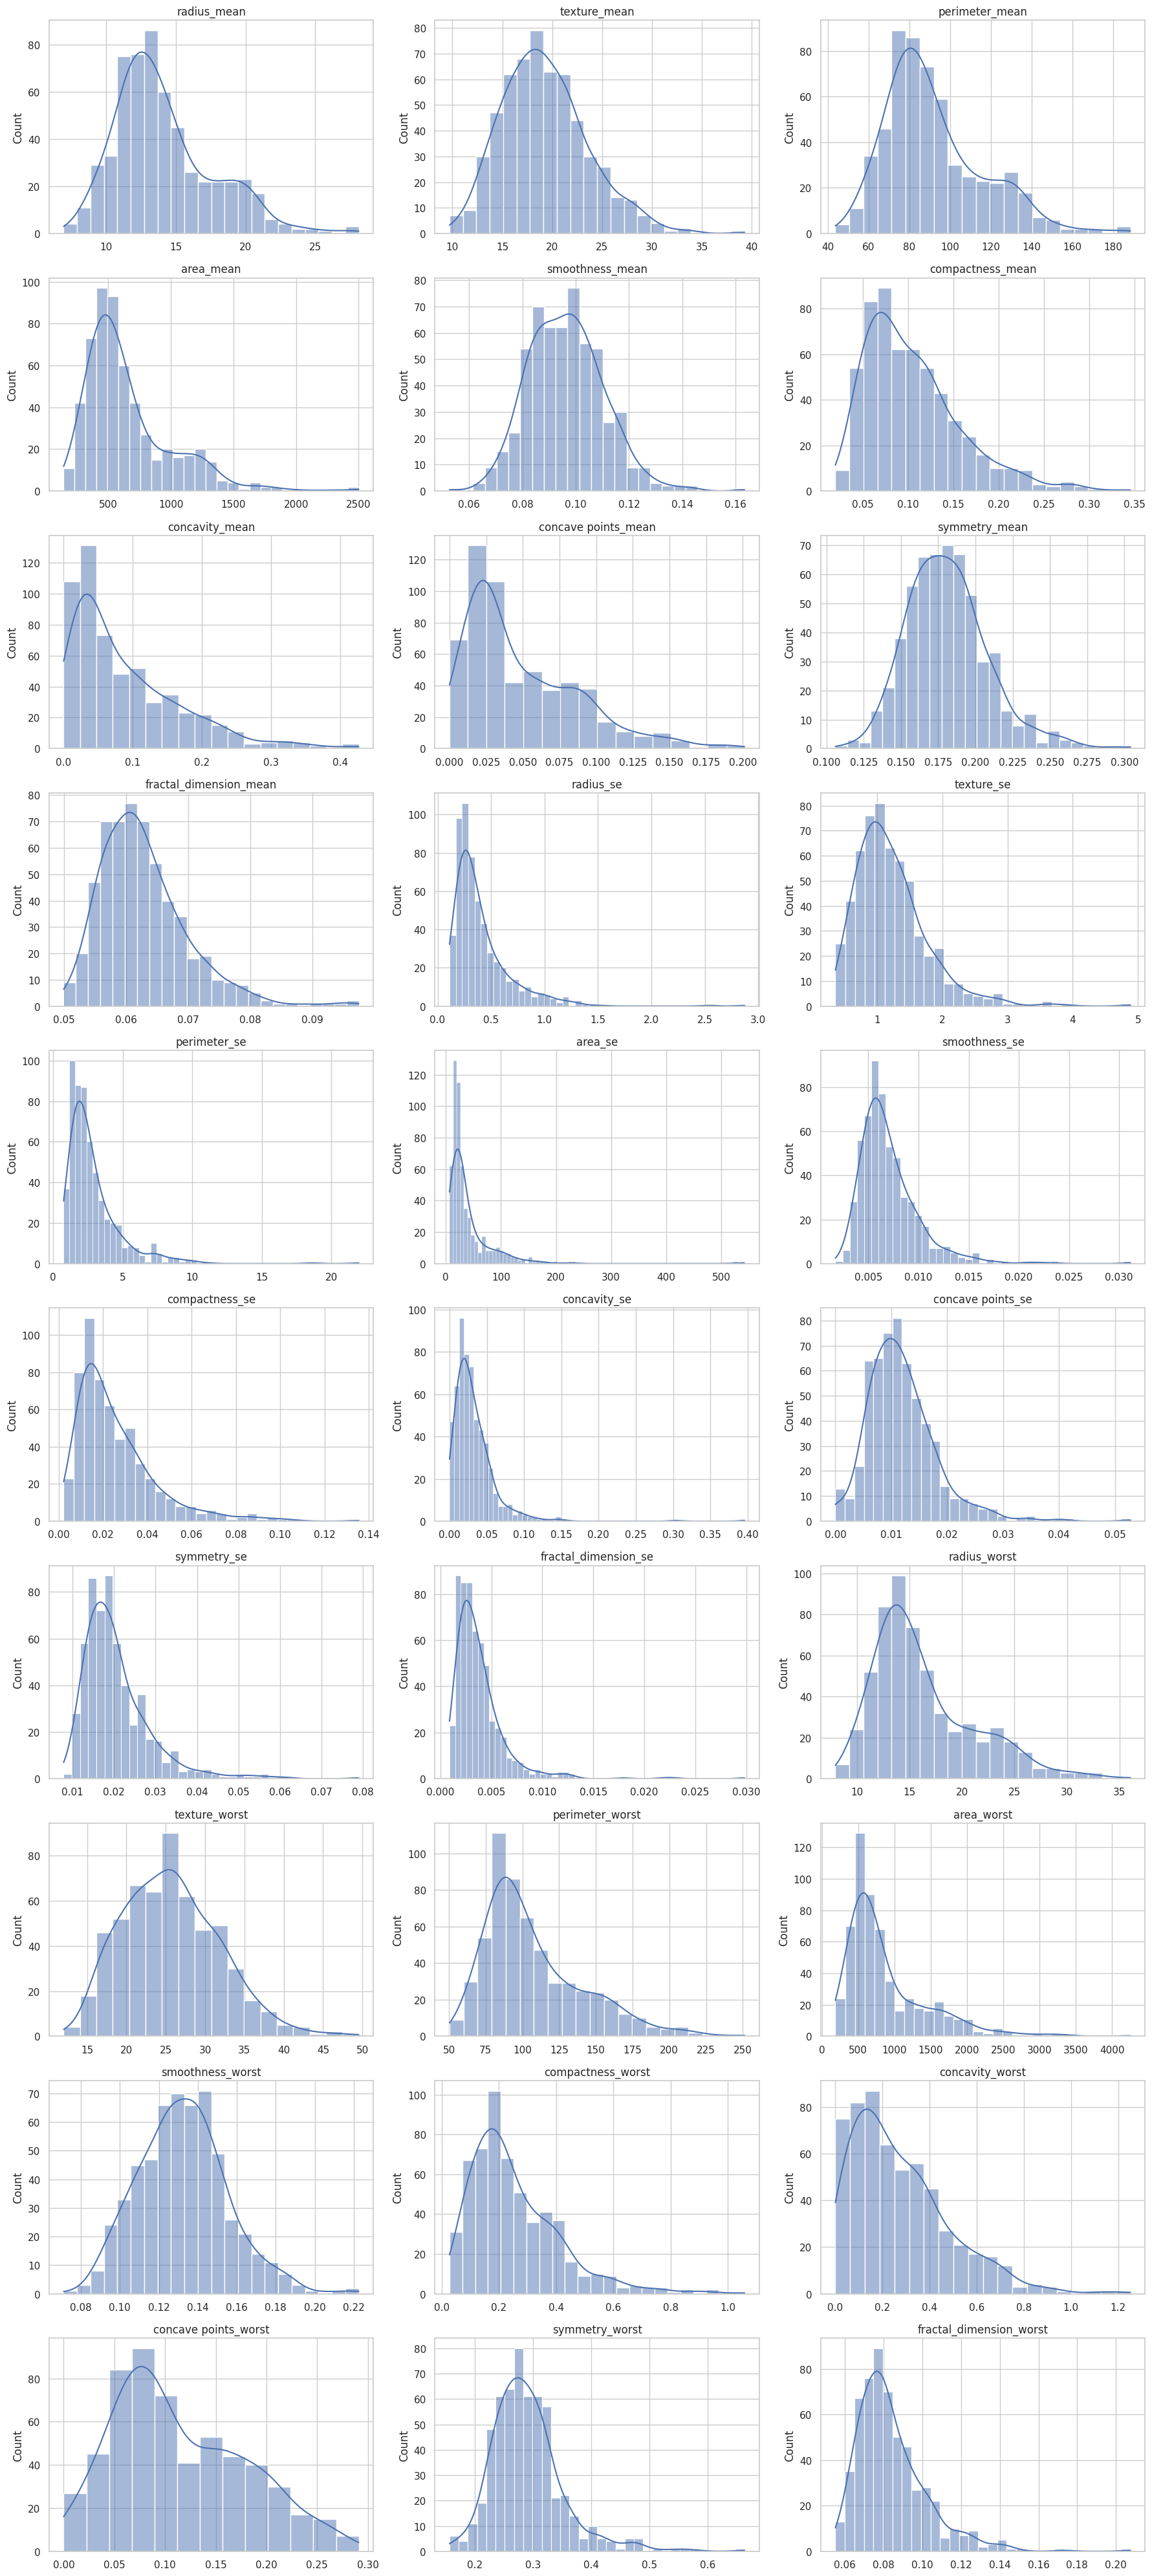

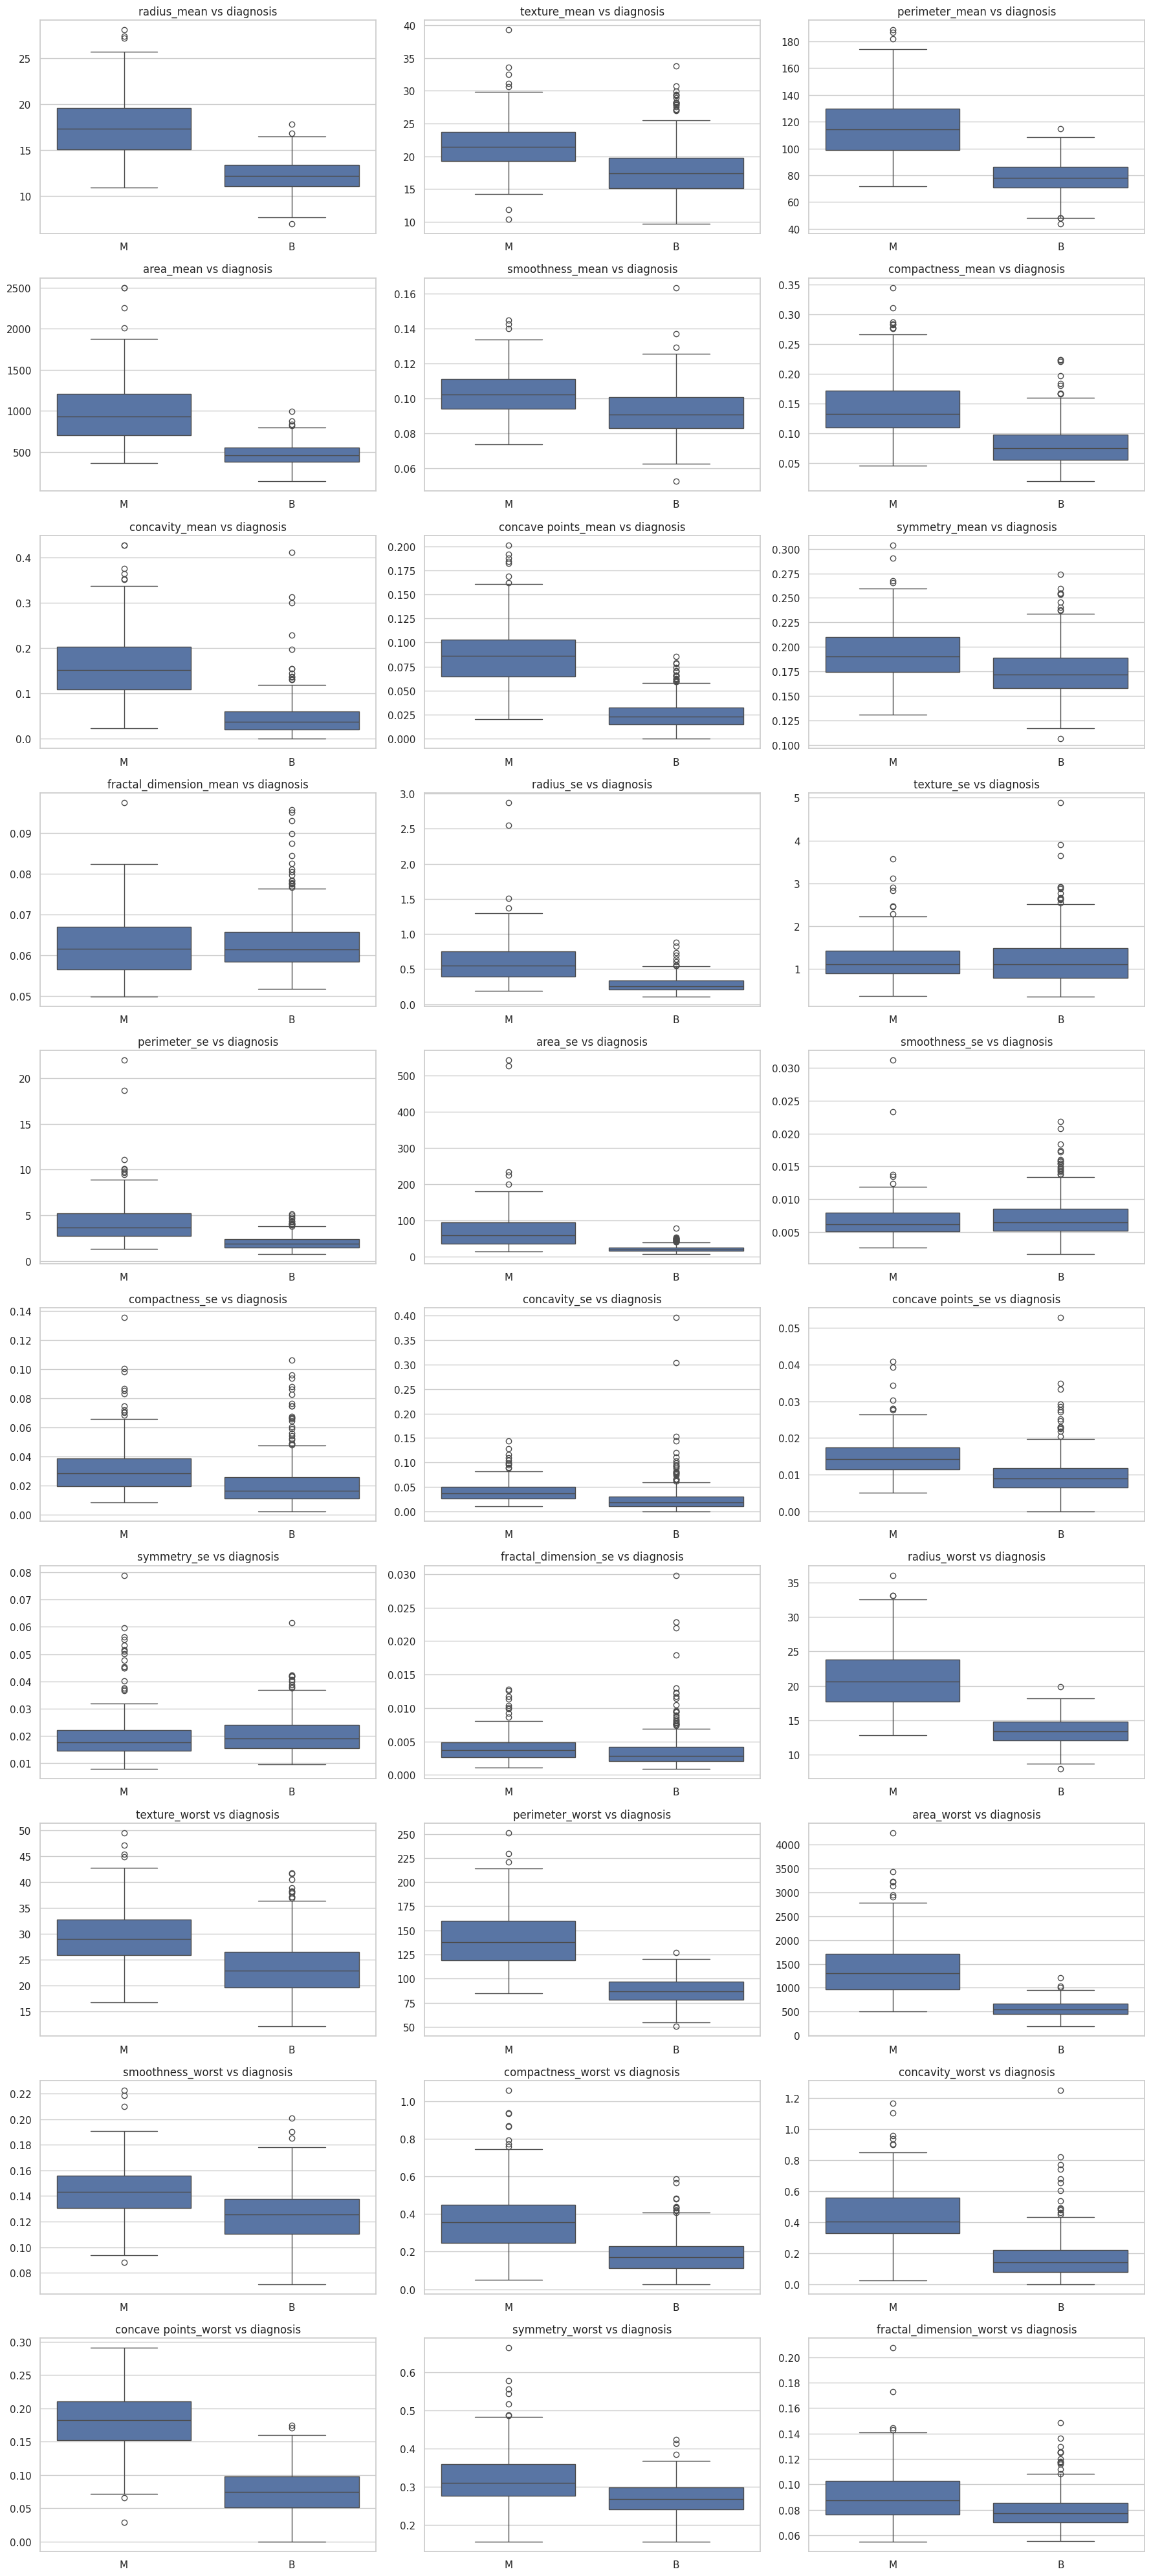

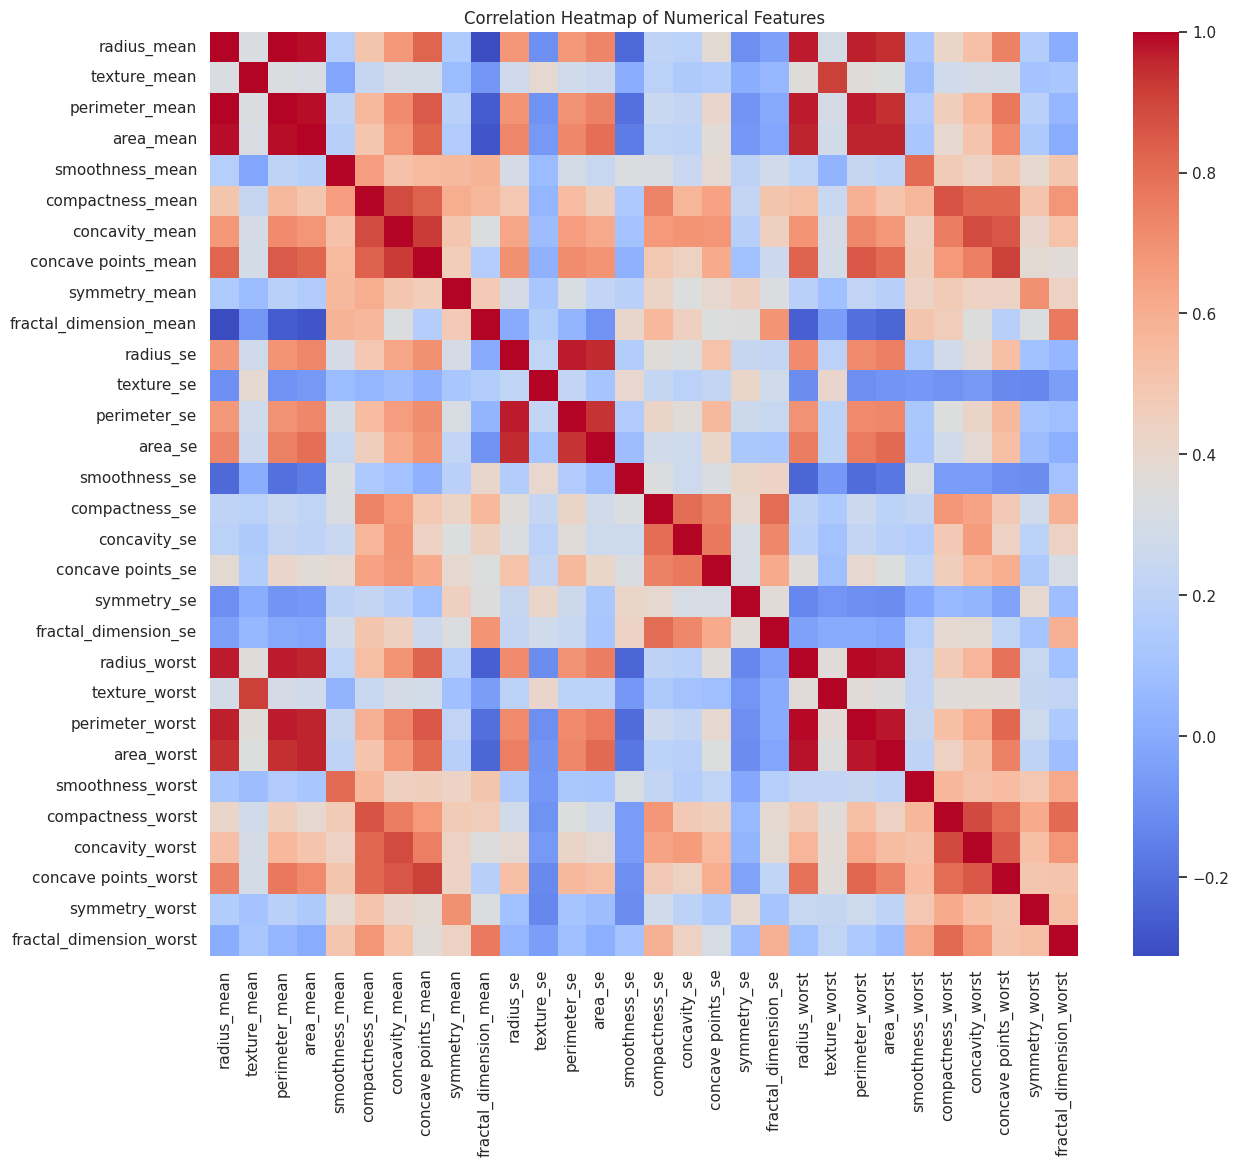

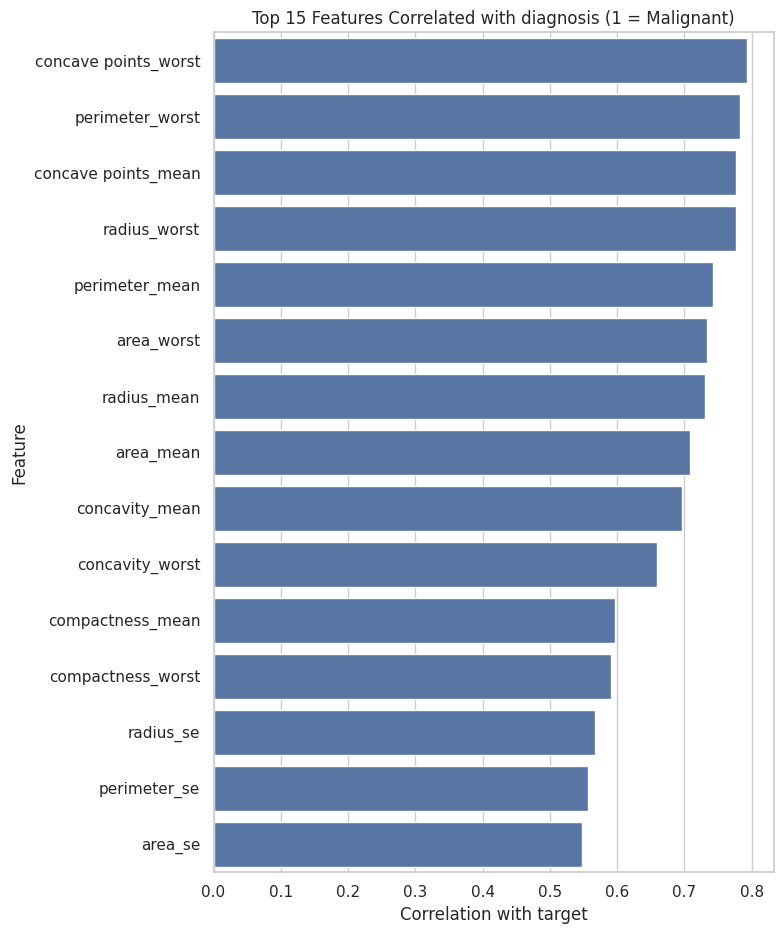

In [24]:
dataset_basic_info(df)

display(summary_stats_numerical(df))
display(summary_stats_categorical(df))

plot_univariate_categorical(df, [TARGET_COL])  # Class balance
plot_univariate_numerical(df, num_cols)

plot_bivariate_numerical_vs_target(df, target=TARGET_COL, num_columns=num_cols, kind="box")

plot_correlation_heatmap(df, num_columns=num_cols, annot=False)
top_corr = plot_feature_target_correlation(df, target=TARGET_COL, num_columns=num_cols, top_n=15)


In [25]:
def drop_irrelevant_features(df, irrelevant_cols=None):
    """
    Removes irrelevant columns like IDs.
    """
    if irrelevant_cols is None:
        irrelevant_cols = ["id"]  # default

    df_clean = df.drop(columns=[c for c in irrelevant_cols if c in df.columns])
    return df_clean


In [26]:
df = drop_irrelevant_features(df)


In [27]:
def handle_missing_values(df):
    """
    Treat missing values:
    - numerical: median
    - categorical: mode
    """
    df_filled = df.copy()

    for col in df_filled.columns:
        if df_filled[col].dtype in ["float64", "int64"]:
            df_filled[col] = df_filled[col].fillna(df_filled[col].median())
        else:
            df_filled[col] = df_filled[col].fillna(df_filled[col].mode()[0])

    return df_filled


In [28]:
df = handle_missing_values(df)


In [29]:
def encode_target(df, target_col="diagnosis"):
    df[target_col] = df[target_col].map({"M": 1, "B": 0})
    return df


In [30]:
df = encode_target(df)


In [31]:
def cap_outliers(df):
    """
    Cap outliers using IQR method.
    """
    df_capped = df.copy()

    num_cols = df_capped.select_dtypes(include=["float64", "int64"]).columns

    for col in num_cols:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        df_capped[col] = np.where(df_capped[col] < lower, lower,
                                  np.where(df_capped[col] > upper, upper, df_capped[col]))
    return df_capped


In [32]:
df = cap_outliers(df)


In [33]:
def encode_categorical(df):
    """
    One-hot encodes non-target categorical variables.
    """
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    return df_encoded


In [34]:
df = encode_categorical(df)   # safe: if no categorical, returns unchanged


In [35]:
from sklearn.preprocessing import StandardScaler

def scale_numerical(df, target_col="diagnosis"):
    """
    Scales numerical features using StandardScaler.
    Returns scaled df and scaler object.
    """
    df_scaled = df.copy()

    num_cols = df_scaled.select_dtypes(include=["float64", "int64"]).columns.tolist()
    num_cols = [c for c in num_cols if c != target_col]

    scaler = StandardScaler()
    df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

    return df_scaled, scaler


In [36]:
df, scaler = scale_numerical(df)


In [37]:
def preprocess_pipeline(df, irrelevant=["id"], target="diagnosis"):
    """
    Full preprocessing pipeline:
    1. Remove irrelevant features
    2. Missing value treatment
    3. Target encoding
    4. Outlier treatment
    5. Categorical encoding
    6. Scaling
    Returns processed df + scaler
    """

    df_p = df.copy()

    df_p = drop_irrelevant_features(df_p, irrelevant)
    df_p = handle_missing_values(df_p)
    df_p = encode_target(df_p, target)
    df_p = cap_outliers(df_p)
    df_p = encode_categorical(df_p)

    df_p, scaler = scale_numerical(df_p, target)

    return df_p, scaler


In [38]:
processed_df, scaler = preprocess_pipeline(df)
processed_df.head()


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,NaN,1.177,-2.121,1.357,1.184,1.619,2.541,2.647e+00,2.621,2.349,2.512,2.281,-0.604,2.343,2.111,-0.198,1.639,1.152,0.779,1.520,1.463,2.006,-1.375,2.440,2.288,1.345,2.642,2.246,2.296,2.444,2.225
1,NaN,1.950,-0.355,1.796,2.249,-0.843,-0.498,-4.973e-04,0.575,0.018,-0.925,0.781,-0.957,0.499,1.612,-0.686,-0.769,-0.556,0.328,-0.938,-0.033,1.921,-0.370,1.632,2.288,-0.377,-0.443,-0.138,1.087,-0.234,0.355
2,NaN,1.686,0.477,1.670,1.846,0.975,1.149,1.496e+00,2.110,1.005,-0.408,1.774,-0.848,1.345,2.111,-0.301,1.038,0.403,1.638,0.374,0.551,1.612,-0.020,1.434,1.808,0.547,1.223,0.921,1.955,1.369,0.265
3,NaN,-0.792,0.269,-0.606,-0.831,2.738,2.541,2.092e+00,1.507,2.521,2.518,0.545,-0.087,0.532,-0.318,0.928,2.474,1.292,1.289,2.423,2.492,-0.278,0.141,-0.245,-0.594,2.596,2.642,2.119,2.176,2.444,2.482
4,NaN,1.866,-1.175,1.892,2.154,0.295,0.599,1.504e+00,1.483,0.006,-0.589,1.831,-0.859,1.954,2.111,1.916,0.003,1.306,1.322,-0.379,0.857,1.387,-1.484,1.425,1.526,0.233,-0.314,0.665,0.729,-0.952,-0.411


In [42]:
def encode_target(df, target_col="diagnosis"):
    """
    Encodes diagnosis:
    - If values are 'M'/'B' -> map to 1/0
    - If already numeric 0/1 -> leave as is
    """
    df = df.copy()

    # If already numeric 0/1, do nothing
    unique_vals = set(df[target_col].dropna().unique())
    if unique_vals <= {0, 1}:
        return df

    mapping = {"M": 1, "B": 0}
    df[target_col] = df[target_col].map(mapping)
    return df


In [43]:
def preprocess_pipeline(df, irrelevant=["id"], target="diagnosis"):
    """
    Full preprocessing pipeline:
    1. Remove irrelevant features
    2. Missing value treatment
    3. Target encoding
    4. Outlier treatment
    5. Categorical encoding
    6. Scaling
    Returns processed df + scaler
    """
    df_p = df.copy()

    df_p = drop_irrelevant_features(df_p, irrelevant)
    df_p = handle_missing_values(df_p)
    df_p = encode_target(df_p, target)
    df_p = cap_outliers(df_p)
    df_p = encode_categorical(df_p)

    df_p, scaler = scale_numerical(df_p, target)

    return df_p, scaler


In [44]:
import pandas as pd

# Reload original data
df = pd.read_csv("/content/breast-cancer.csv")  # adjust path if needed

# Run full preprocessing ONCE
processed_df, scaler = preprocess_pipeline(df)

# Sanity check
print("NaNs in diagnosis:", processed_df["diagnosis"].isna().sum())
print(processed_df["diagnosis"].value_counts(dropna=False))


NaNs in diagnosis: 0
diagnosis
0.0    357
1.0    212
Name: count, dtype: int64


In [45]:
from sklearn.model_selection import train_test_split

X = processed_df.drop("diagnosis", axis=1)
y = processed_df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [46]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
import pandas as pd
import numpy as np

def evaluate_classifier(model_name, model, X_train, y_train, X_test, y_test):
    """
    Fits model (if not already), predicts, and returns:
    - evaluation DataFrame (indexed by model_name)
    - y_pred, y_proba
    """
    # Fit if not fitted
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Some models may not have predict_proba (e.g., SVM with linear kernel sometimes)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        # scale to [0,1] using min-max for ROC-AUC approximation
        decision_scores = model.decision_function(X_test)
        y_proba = (decision_scores - decision_scores.min()) / (decision_scores.max() - decision_scores.min())
    else:
        y_proba = None

    accuracy = accuracy_score(y_test, y_pred)
    precision_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    eval_dict = {
        "model": model_name,
        "accuracy": accuracy,
        "precision_1": precision_1,
        "recall_1": recall_1,
        "f1_1": f1_1,
        "roc_auc": roc_auc
    }

    evaluation_df = pd.DataFrame(eval_dict, index=[model_name])

    print(f"\n===== {model_name} Evaluation =====")
    print("Accuracy :", round(accuracy, 4))
    print("Precision (class 1):", round(precision_1, 4))
    print("Recall (class 1)   :", round(recall_1, 4))
    print("F1-score (class 1) :", round(f1_1, 4))
    print("ROC-AUC            :", round(roc_auc, 4) if not np.isnan(roc_auc) else "NA")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return evaluation_df, y_pred, y_proba


In [47]:
from xgboost import XGBClassifier

def build_xgb_base():
    """
    Returns a base XGBClassifier with reasonable default params.
    """
    xgb_clf = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=1.0,
        objective="binary:logistic",
        random_state=42,
        eval_metric="logloss",
        n_jobs=-1
    )
    return xgb_clf

# Create and evaluate base model
xgb_base = build_xgb_base()
xgb_base_evaluation, xgb_base_pred, xgb_base_proba = evaluate_classifier(
    "XGBoost_Base", xgb_base, X_train, y_train, X_test, y_test
)

xgb_base_evaluation



===== XGBoost_Base Evaluation =====
Accuracy : 0.9649
Precision (class 1): 1.0
Recall (class 1)   : 0.9048
F1-score (class 1) : 0.95
ROC-AUC            : 0.996

Confusion Matrix:
[[72  0]
 [ 4 38]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        72
         1.0       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



,model,accuracy,precision_1,recall_1,f1_1,roc_auc
XGBoost_Base,XGBoost_Base,0.965,1.0,0.905,0.95,0.996


In [48]:
from sklearn.model_selection import GridSearchCV

def tune_xgb_hyperparameters(X_train, y_train, cv=5):
    """
    Performs hyperparameter tuning for XGBClassifier using GridSearchCV.
    Optimizes for recall of positive class (malignant = 1).
    """
    xgb_clf = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    )

    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [3, 4, 5],
        "learning_rate": [0.01, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    }

    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid=param_grid,
        scoring="recall",      # recall for positive class
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print("✅ Best Params:", grid_search.best_params_)
    print("✅ Best CV Recall:", grid_search.best_score_)

    best_model = grid_search.best_estimator_
    return best_model, grid_search


In [49]:
best_xgb, xgb_grid = tune_xgb_hyperparameters(X_train, y_train, cv=5)

xgb_tuned_evaluation, xgb_tuned_pred, xgb_tuned_proba = evaluate_classifier(
    "XGBoost_Tuned", best_xgb, X_train, y_train, X_test, y_test
)

xgb_tuned_evaluation


Fitting 5 folds for each of 48 candidates, totalling 240 fits
✅ Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
✅ Best CV Recall: 0.9647058823529411

===== XGBoost_Tuned Evaluation =====
Accuracy : 0.9649
Precision (class 1): 1.0
Recall (class 1)   : 0.9048
F1-score (class 1) : 0.95
ROC-AUC            : 0.9954

Confusion Matrix:
[[72  0]
 [ 4 38]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        72
         1.0       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



,model,accuracy,precision_1,recall_1,f1_1,roc_auc
XGBoost_Tuned,XGBoost_Tuned,0.965,1.0,0.905,0.95,0.995


In [50]:
from sklearn.ensemble import RandomForestClassifier

def build_rf_base():
    """
    Returns a base RandomForestClassifier with reasonable defaults.
    """
    rf_clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    return rf_clf

# Build and evaluate base RF model
rf_base = build_rf_base()

rf_base_evaluation, rf_base_pred, rf_base_proba = evaluate_classifier(
    "RandomForest_Base", rf_base, X_train, y_train, X_test, y_test
)

rf_base_evaluation



===== RandomForest_Base Evaluation =====
Accuracy : 0.9737
Precision (class 1): 1.0
Recall (class 1)   : 0.9286
F1-score (class 1) : 0.963
ROC-AUC            : 0.9934

Confusion Matrix:
[[72  0]
 [ 3 39]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        72
         1.0       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



,model,accuracy,precision_1,recall_1,f1_1,roc_auc
RandomForest_Base,RandomForest_Base,0.974,1.0,0.929,0.963,0.993


In [51]:
from sklearn.model_selection import GridSearchCV

def tune_rf_hyperparameters(X_train, y_train, cv=5):
    """
    Hyperparameter tuning for RandomForestClassifier using GridSearchCV.
    Scoring: recall for positive class.
    """
    rf_clf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    )

    param_grid = {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 4, 6, 8],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"]
    }

    grid_search = GridSearchCV(
        estimator=rf_clf,
        param_grid=param_grid,
        scoring="recall",
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print("✅ Best Params:", grid_search.best_params_)
    print("✅ Best CV Recall:", grid_search.best_score_)

    best_model = grid_search.best_estimator_
    return best_model, grid_search


In [52]:
best_rf, rf_grid = tune_rf_hyperparameters(X_train, y_train, cv=5)

rf_evaluation, rf_pred, rf_proba = evaluate_classifier(
    "RandomForest_Tuned", best_rf, X_train, y_train, X_test, y_test
)

rf_evaluation



Fitting 5 folds for each of 216 candidates, totalling 1080 fits
✅ Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
✅ Best CV Recall: 0.9470588235294117

===== RandomForest_Tuned Evaluation =====
Accuracy : 0.9737
Precision (class 1): 1.0
Recall (class 1)   : 0.9286
F1-score (class 1) : 0.963
ROC-AUC            : 0.9983

Confusion Matrix:
[[72  0]
 [ 3 39]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        72
         1.0       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



,model,accuracy,precision_1,recall_1,f1_1,roc_auc
RandomForest_Tuned,RandomForest_Tuned,0.974,1.0,0.929,0.963,0.998


In [53]:
from sklearn.svm import SVC

def build_svm_base():
    """
    Returns a base SVM (RBF kernel) model.
    """
    svm_clf = SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,  # Enables predict_proba for ROC-AUC
        random_state=42
    )
    return svm_clf

# Build and evaluate base SVM model
svm_base = build_svm_base()

svm_base_evaluation, svm_base_pred, svm_base_proba = evaluate_classifier(
    "SVM_Base", svm_base, X_train, y_train, X_test, y_test
)

svm_base_evaluation



===== SVM_Base Evaluation =====
Accuracy : 0.9737
Precision (class 1): 0.9756
Recall (class 1)   : 0.9524
F1-score (class 1) : 0.9639
ROC-AUC            : 0.996

Confusion Matrix:
[[71  1]
 [ 2 40]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98        72
         1.0       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



,model,accuracy,precision_1,recall_1,f1_1,roc_auc
SVM_Base,SVM_Base,0.974,0.976,0.952,0.964,0.996


In [54]:
from sklearn.model_selection import GridSearchCV

def tune_svm_hyperparameters(X_train, y_train, cv=5):
    """
    Hyperparameter tuning for SVM with RBF kernel using GridSearchCV.
    Scoring: recall for positive class.
    """
    svm_clf = SVC(
        kernel="rbf",
        probability=True,
        random_state=42
    )

    param_grid = {
        "C": [0.1, 1, 10, 100],
        "gamma": ["scale", 0.01, 0.001, 0.0001]
    }

    grid_search = GridSearchCV(
        estimator=svm_clf,
        param_grid=param_grid,
        scoring="recall",
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print("✅ Best Params:", grid_search.best_params_)
    print("✅ Best CV Recall:", grid_search.best_score_)

    best_model = grid_search.best_estimator_
    return best_model, grid_search


In [55]:
best_svm, svm_grid = tune_svm_hyperparameters(X_train, y_train, cv=5)

svm_evaluation, svm_pred, svm_proba = evaluate_classifier(
    "SVM_Tuned", best_svm, X_train, y_train, X_test, y_test
)

svm_evaluation


Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ Best Params: {'C': 100, 'gamma': 'scale'}
✅ Best CV Recall: 0.9647058823529411

===== SVM_Tuned Evaluation =====
Accuracy : 0.9737
Precision (class 1): 0.9756
Recall (class 1)   : 0.9524
F1-score (class 1) : 0.9639
ROC-AUC            : 0.9884

Confusion Matrix:
[[71  1]
 [ 2 40]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98        72
         1.0       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



,model,accuracy,precision_1,recall_1,f1_1,roc_auc
SVM_Tuned,SVM_Tuned,0.974,0.976,0.952,0.964,0.988


In [56]:
all_evaluations = [xgb_tuned_evaluation, rf_evaluation, svm_evaluation]
results = pd.concat(all_evaluations)

# Sort by 'recall_1'
results = results.sort_values(by='recall_1', ascending=False).round(2)
results


,model,accuracy,precision_1,recall_1,f1_1,roc_auc
SVM_Tuned,SVM_Tuned,0.97,0.98,0.95,0.96,0.99
RandomForest_Tuned,RandomForest_Tuned,0.97,1.00,0.93,0.96,1.00
XGBoost_Tuned,XGBoost_Tuned,0.96,1.00,0.90,0.95,1.00


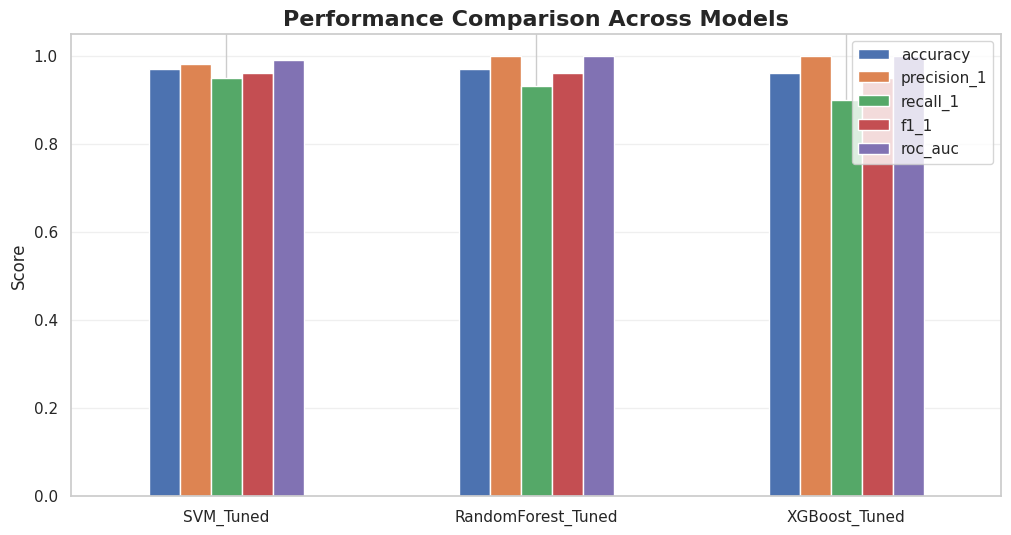

In [57]:
metrics = ["accuracy", "precision_1", "recall_1", "f1_1", "roc_auc"]

results[metrics].plot(kind="bar", figsize=(12,6))
plt.title("Performance Comparison Across Models", fontsize=16, fontweight="bold")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.show()
